In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/scaler/scaler_model.joblib
/kaggle/input/test-data/2024-2025.csv
/kaggle/input/real-residual/real_residual.npy
/kaggle/input/sequences/timegan_517day_sequences.npy
/kaggle/input/synthetic-residuals/residual_sims.npy


## 

In [4]:
#!/usr/bin/env python
# fast-diverse-v7.5α-final (2025-08-06)
# =============================================================
# Enhanced TimeGAN for capturing seasonality & diversity
# =============================================================
import numpy as np, random, torch, torch.nn as nn, torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad
import argparse

# ---------- reproducibility --------------------------------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# ---------- constants & hyper-params ------------------------------
SEQ_LEN, N_RESID = 517, 3
EMB_DOY, EMB_DOW, EMB_MON = 16, 4, 6
CAL_DIM                   = EMB_DOY + EMB_DOW + EMB_MON
HIDDEN, NLAYERS           = 128, 4
NUM_MODES                 = 5

BATCH = 64
AE_EP, SUP_EP, ADV_EP = 20, 20, 100
LR_AE = LR_SUP = 2e-4
LR_G  = 1e-4
LR_D  = 1e-5

λ_S = 500
λ_V  = 30
λ_X  = 20
VAR_W = 50
DIV_W = 10
DIV_MARGIN = 0.7

CRIT_ITERS = 3
GP_LAMBDA  = 40
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ---------- data loader -------------------------------------------
def get_loader(path):
    arr = np.load(path).astype(np.float32)
    return DataLoader(TensorDataset(torch.as_tensor(arr).to(DEVICE)),
                      batch_size=BATCH, shuffle=True, drop_last=True)

def sample_Z(bsz):
    sigmas = torch.rand(SEQ_LEN, 1, 1, device=DEVICE)*1.5 + 0.5
    z = torch.randn(SEQ_LEN, bsz, HIDDEN, device=DEVICE)
    modes = torch.randint(0, NUM_MODES, (bsz,), device=DEVICE)
    mode_latent = mode_embed(modes).unsqueeze(1).repeat(1, SEQ_LEN, 1)
    return (sigmas * z).permute(1,0,2) + mode_latent

# ---------- calendar embedding ------------------------------------
class CalEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.doy_embed = nn.Embedding(366, EMB_DOY, max_norm=1.0)
        self.dow_embed = nn.Embedding(7, EMB_DOW, max_norm=1.0)
        self.mon_embed = nn.Embedding(12, EMB_MON, max_norm=1.0)
        self.proj = nn.Sequential(nn.Linear(CAL_DIM, CAL_DIM), nn.ReLU(), nn.Linear(CAL_DIM, CAL_DIM))

    def forward(self, doy, dow, mon):
        x = torch.cat([self.doy_embed(doy), self.dow_embed(dow), self.mon_embed(mon)], -1)
        return self.proj(x)

# ---------- backbone blocks ---------------------------------------
class LayerNormGRU(nn.Module):
    def __init__(self, fin, fout):
        super().__init__()
        self.rnn = nn.GRU(fin, fout, NLAYERS, batch_first=True)
        self.ln  = nn.LayerNorm(fout)
    def forward(self,x):
        out,_ = self.rnn(x); return self.ln(out)

class FiLM_Attn(nn.Module):
    def __init__(self, hid):
        super().__init__()
        self.gru = nn.GRU(hid, hid, batch_first=True)
        self.attn = nn.MultiheadAttention(hid, num_heads=8, batch_first=True)
        self.gamma = nn.Linear(CAL_DIM, hid)
        self.beta = nn.Linear(CAL_DIM, hid)

    def forward(self,h,c):
        h,_  = self.gru(h)
        h,_  = self.attn(h,h,h)
        return self.gamma(c)*h + self.beta(c)

# ---------- mode embedding ----------------------------------------
mode_embed = nn.Embedding(NUM_MODES, HIDDEN).to(DEVICE)

# ---------- TimeGAN components ------------------------------------
class Embedder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(LayerNormGRU(N_RESID+CAL_DIM, HIDDEN), nn.Linear(HIDDEN, HIDDEN))
    def forward(self,r,c): return self.net(torch.cat([r,c], -1))

class Recovery(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgru = LayerNormGRU(HIDDEN+CAL_DIM, HIDDEN)
        self.heads = nn.ModuleList(
            [nn.Sequential(nn.Linear(HIDDEN, 32), nn.ReLU(), nn.Linear(32, 1)) for _ in range(N_RESID)])
    def forward(self,h,c):
        core = self.rgru(torch.cat([h,c], -1))
        outs = [head(core) for head in self.heads]
        return torch.cat(outs, -1)

class Generator(nn.Module):
    def __init__(self): super().__init__(); self.block = FiLM_Attn(HIDDEN)
    def forward(self,z,c): return self.block(z,c)

class Supervisor(nn.Module):
    def __init__(self): super().__init__(); self.block = FiLM_Attn(HIDDEN)
    def forward(self,h,c): return self.block(h,c)

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn  = nn.GRU(HIDDEN+CAL_DIM, 128, NLAYERS, batch_first=True, dropout=0.25)
        self.lin  = nn.Linear(128, 1)
    def forward(self,h,c):
        out,_ = self.rnn(torch.cat([h,c], -1)); return self.lin(out)

# ---------- gradient penalty --------------------------------------
def gp(D, real, fake, c):
    t = torch.randint(real.size(1), (1,)).item()
    real_t, fake_t = real[:,t], fake[:,t]
    c_t = c[:,t].detach()
    eps = torch.rand(real_t.size(0),1, device=DEVICE)
    hat = (eps*real_t + (1-eps)*fake_t).requires_grad_(True)
    with torch.backends.cudnn.flags(enabled=False):
        out = D(hat.unsqueeze(1), c_t.unsqueeze(1))
    g, = grad(out, hat, torch.ones_like(out), create_graph=True)
    return ((g.norm(2, dim=-1) - 1)**2).mean()

# ---------- training loop -----------------------------------------
def train(npy):
    loader = get_loader(npy)
    Cal = CalEmbedding().to(DEVICE)
    E,R,G,S,D = [m.to(DEVICE) for m in
                 (Embedder(), Recovery(), Generator(), Supervisor(), Discriminator())]

    opt_ae  = optim.Adam(list(E.parameters())+list(R.parameters()), lr=LR_AE)
    opt_sup = optim.Adam(S.parameters(), lr=LR_SUP)
    opt_G   = optim.Adam(list(G.parameters())+list(S.parameters()), lr=LR_G, betas=(0.5,0.9))
    opt_D   = optim.Adam(D.parameters(), lr=LR_D, betas=(0.5,0.9))
    mse = nn.MSELoss()

    # ------ auto-encoder ----------------------------------------
    for ep in range(1, AE_EP+1):
        for (x,) in loader:
            r   = x[:,:,:3]
            doy = x[:,:,3].long()-1; dow = x[:,:,4].long(); mon = x[:,:,6].long()-1
            c   = Cal(doy,dow,mon)
            loss = mse(R(E(r,c), c), r)
            opt_ae.zero_grad(); loss.backward(); opt_ae.step()
        print(f'[AE] {ep:02}/{AE_EP} {loss:.3f}')

    # ------ supervisor -----------------------------------------
    E.eval(); E.requires_grad_(False)
    for ep in range(1, SUP_EP+1):
        for (x,) in loader:
            r   = x[:,:,:3]
            doy = x[:,:,3].long()-1; dow = x[:,:,4].long(); mon = x[:,:,6].long()-1
            c   = Cal(doy,dow,mon)
            with torch.no_grad(): h = E(r,c)
            loss = mse(h[:,1:], S(h[:,:-1], c[:,1:]))
            opt_sup.zero_grad(); loss.backward(); opt_sup.step()
        print(f'[SUP] {ep:02}/{SUP_EP} {loss:.3f}')
    E.train(); E.requires_grad_(True)

    # ------ adversarial ----------------------------------------
    for ep in range(1, ADV_EP+1):
        for (x,) in loader:
            r = x[:,:,:3]
            doy = x[:,:,3].long()-1; dow = x[:,:,4].long(); mon = x[:,:,6].long()-1
            c  = Cal(doy,dow,mon)

            # critic
            for _ in range(CRIT_ITERS):
                c_det = c.detach()
                h_real = E(r,c_det).detach()
                with torch.no_grad():
                    h_fake = S(G(sample_Z(r.size(0)), c_det), c_det)
                d_loss = D(h_fake,c_det).mean() - D(h_real,c_det).mean() \
                       + GP_LAMBDA*gp(D,h_real,h_fake,c_det)
                opt_D.zero_grad(); d_loss.backward(); opt_D.step()

            # generator
            h_hat = S(G(sample_Z(r.size(0)), c), c)
            g_adv = -D(h_hat,c).mean()
            with torch.no_grad(): h_lat = E(r,c)
            g_sup = mse(h_lat[:,1:], S(h_lat[:,:-1], c[:,1:]))

            mu_r,sd_r = h_lat.mean((0,1)), h_lat.std((0,1))
            mu_f,sd_f = h_hat.mean((0,1)), h_hat.std((0,1))
            g_latmom  = (mu_r-mu_f).abs().mean() + (sd_r-sd_f).abs().mean()

            x_fake = R(h_hat,c) + 0.02*torch.randn_like(h_hat[:,:,:1])
            muX_r,sdX_r = r.mean((0,1)), r.std((0,1))
            muX_f,sdX_f = x_fake.mean((0,1)), x_fake.std((0,1))
            g_datamom = (muX_r-muX_f).abs().mean() + (sdX_r-sdX_f).abs().mean()

            var_r = r.var(dim=(0,1)); var_f = x_fake.var(dim=(0,1))
            var_loss = (var_r/(var_f+1e-6) + var_f/(var_r+1e-6) - 2).mean()

            lat = h_hat.mean(dim=1)
            pd  = (lat.unsqueeze(0)-lat.unsqueeze(1)).pow(2).sum(-1)
            mask = ~torch.eye(lat.size(0), device=lat.device, dtype=torch.bool)
            div_loss = (1.0 / (pd[mask] + 1e-6)).mean()

            g_loss = (g_adv +
                      λ_S   * g_sup +
                      λ_V   * g_latmom +
                      λ_X   * g_datamom +
                      VAR_W * var_loss +
                      DIV_W * div_loss)
            opt_G.zero_grad(); g_loss.backward(); opt_G.step()

            ae_loss = mse(R(E(r,c_det),c_det), r)
            opt_ae.zero_grad(); ae_loss.backward(); opt_ae.step()

        if ep%10==0 or ep==1:
            print(f'[ADV] {ep:03}/{ADV_EP} | D {d_loss:.2f}  '
                  f'G {g_loss:.1f}  AE {ae_loss:.4f}')

    torch.save(G.state_dict(),   'generator.pth')
    torch.save(S.state_dict(),   'supervisor.pth')
    torch.save(R.state_dict(),   'recovery.pth')
    torch.save(Cal.state_dict(), 'calembed.pth')
    torch.save(mode_embed.state_dict(), 'mode_embed.pth')
    print('weights saved')



In [5]:
train("/kaggle/input/sequences/timegan_517day_sequences.npy")

[AE] 01/20 0.460
[AE] 02/20 0.384
[AE] 03/20 0.416
[AE] 04/20 0.343
[AE] 05/20 0.275
[AE] 06/20 0.099
[AE] 07/20 0.038
[AE] 08/20 0.023
[AE] 09/20 0.009
[AE] 10/20 0.005
[AE] 11/20 0.003
[AE] 12/20 0.003
[AE] 13/20 0.004
[AE] 14/20 0.003
[AE] 15/20 0.003
[AE] 16/20 0.009
[AE] 17/20 0.003
[AE] 18/20 0.001
[AE] 19/20 0.002
[AE] 20/20 0.003
[SUP] 01/20 0.698
[SUP] 02/20 0.398
[SUP] 03/20 0.217
[SUP] 04/20 0.143
[SUP] 05/20 0.125
[SUP] 06/20 0.115
[SUP] 07/20 0.116
[SUP] 08/20 0.110
[SUP] 09/20 0.104
[SUP] 10/20 0.103
[SUP] 11/20 0.109
[SUP] 12/20 0.107
[SUP] 13/20 0.100
[SUP] 14/20 0.103
[SUP] 15/20 0.099
[SUP] 16/20 0.095
[SUP] 17/20 0.094
[SUP] 18/20 0.094
[SUP] 19/20 0.095
[SUP] 20/20 0.102
[ADV] 001/100 | D 39.23  G 2801.3  AE 0.0026
[ADV] 010/100 | D 14.70  G 194.3  AE 0.0008
[ADV] 020/100 | D -12.83  G 319.6  AE 0.0005
[ADV] 030/100 | D -16.34  G 89.2  AE 0.0015
[ADV] 040/100 | D -18.48  G 86.2  AE 0.0006
[ADV] 050/100 | D -20.48  G 87.3  AE 0.0003
[ADV] 060/100 | D -22.45  G 84.2  

In [6]:
#!/usr/bin/env python
# generate_timegan_final.py – inference for fast-diverse-v7.5α-final
# ===============================================================
import torch, torch.nn as nn, numpy as np, pandas as pd

# -------- constants (mirror training script exactly) ---------------------
SEQ_LEN, N_RESID = 517, 3
EMB_DOY, EMB_DOW, EMB_MON = 16, 4, 6
CAL_DIM   = EMB_DOY + EMB_DOW + EMB_MON
HIDDEN, NLAYERS = 128, 4
NUM_MODES = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -------- enhanced calendar embedding ------------------------------------
class CalEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.doy_embed = nn.Embedding(366, EMB_DOY, max_norm=1.0)
        self.dow_embed = nn.Embedding(7, EMB_DOW, max_norm=1.0)
        self.mon_embed = nn.Embedding(12, EMB_MON, max_norm=1.0)
        self.proj = nn.Sequential(nn.Linear(CAL_DIM, CAL_DIM), nn.ReLU(), nn.Linear(CAL_DIM, CAL_DIM))

    def forward(self, doy, dow, mon):
        x = torch.cat([self.doy_embed(doy), self.dow_embed(dow), self.mon_embed(mon)], -1)
        return self.proj(x)

# -------- backbone blocks ---------------------------------------
class LayerNormGRU(nn.Module):
    def __init__(self, fin, fout):
        super().__init__()
        self.rnn = nn.GRU(fin, fout, NLAYERS, batch_first=True)
        self.ln  = nn.LayerNorm(fout)
    def forward(self,x):
        out,_ = self.rnn(x); return self.ln(out)

class FiLM_Attn(nn.Module):
    def __init__(self, hid):
        super().__init__()
        self.gru = nn.GRU(hid, hid, batch_first=True)
        self.attn = nn.MultiheadAttention(hid, num_heads=8, batch_first=True)
        self.gamma = nn.Linear(CAL_DIM, hid)
        self.beta = nn.Linear(CAL_DIM, hid)

    def forward(self,h,c):
        h,_  = self.gru(h)
        h,_  = self.attn(h,h,h)
        return self.gamma(c)*h + self.beta(c)

# -------- mode embedding ----------------------------------------
mode_embed = nn.Embedding(NUM_MODES, HIDDEN).to(DEVICE)

# -------- TimeGAN components ------------------------------------
class Generator(nn.Module):
    def __init__(self): super().__init__(); self.block = FiLM_Attn(HIDDEN)
    def forward(self,z,c): return self.block(z,c)

class Supervisor(nn.Module):
    def __init__(self): super().__init__(); self.block = FiLM_Attn(HIDDEN)
    def forward(self,h,c): return self.block(h,c)

class Recovery(nn.Module):
    def __init__(self):
        super().__init__()
        self.rgru = LayerNormGRU(HIDDEN+CAL_DIM, HIDDEN)
        self.heads = nn.ModuleList(
            [nn.Sequential(nn.Linear(HIDDEN, 32), nn.ReLU(), nn.Linear(32, 1)) for _ in range(N_RESID)])
    def forward(self,h,c):
        core = self.rgru(torch.cat([h,c], -1))
        outs = [head(core) for head in self.heads]
        return torch.cat(outs, -1)

# -------- load trained weights ---------------------------------
G = Generator().to(DEVICE)
S = Supervisor().to(DEVICE)
R = Recovery ().to(DEVICE)
Cal = CalEmbedding().to(DEVICE)

G.load_state_dict(torch.load('generator.pth',  map_location=DEVICE))
S.load_state_dict(torch.load('supervisor.pth', map_location=DEVICE))
R.load_state_dict(torch.load('recovery.pth',   map_location=DEVICE))
Cal.load_state_dict(torch.load('calembed.pth', map_location=DEVICE))
mode_embed.load_state_dict(torch.load('mode_embed.pth', map_location=DEVICE))

for m in (G,S,R,Cal, mode_embed): m.eval()

# -------- calendar helper ---------------------------------------
def calendar_tensor(start: str, periods: int, batch: int):
    idx  = pd.date_range(start, periods=periods, freq='D')
    doy  = torch.tensor(idx.dayofyear.values - 1, device=DEVICE).long()
    dow  = torch.tensor(idx.dayofweek.values,     device=DEVICE).long()
    mon  = torch.tensor(idx.month.values - 1,     device=DEVICE).long()
    return Cal(doy.unsqueeze(0).repeat(batch,1),
               dow.unsqueeze(0).repeat(batch,1),
               mon.unsqueeze(0).repeat(batch,1))

# -------- latent noise (σ per timestep + mode-code) -------------------------
def sample_Z(bsz):
    sigmas = torch.rand(SEQ_LEN, 1, 1, device=DEVICE)*1.5 + 0.5
    z = torch.randn(SEQ_LEN, bsz, HIDDEN, device=DEVICE)
    modes = torch.randint(0, NUM_MODES, (bsz,), device=DEVICE)
    mode_latent = mode_embed(modes).unsqueeze(1).repeat(1, SEQ_LEN, 1)
    return (sigmas * z).permute(1,0,2) + mode_latent

# -------- scenario generator ------------------------------------
@torch.no_grad()
def generate_scenarios(n_samples=5, start='2024-01-01'):
    c = calendar_tensor(start, SEQ_LEN, n_samples)
    z = sample_Z(n_samples)
    h = S(G(z,c), c)
    x = R(h,c).cpu().numpy()
    return x

# -------- smoke-test --------------------------------------------
if __name__ == "__main__":
    sims = generate_scenarios(100)
    print("Synthetic residuals shape:", sims.shape)

Synthetic residuals shape: (100, 517, 3)


In [7]:
## save the residuals
np.save('residual_sims.npy',sims)

In [8]:
test_df=pd.read_csv("/kaggle/input/test-data/2024-2025.csv")


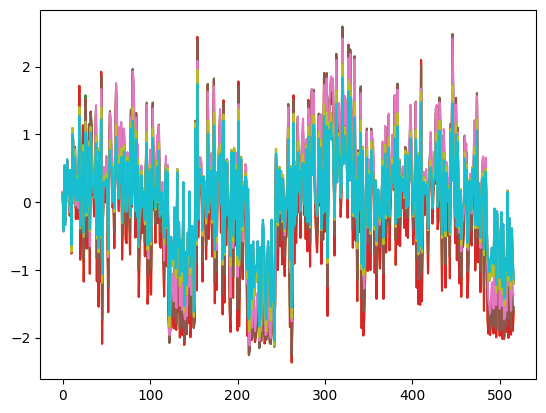

In [12]:
for i in range(10):
    plt.plot(sims[i,:,0])

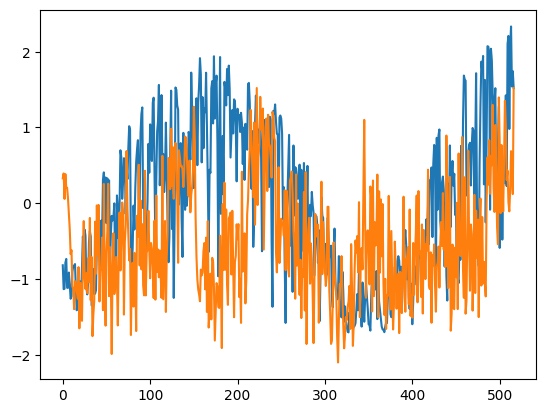

In [11]:
import matplotlib.pyplot as plt
plt.plot(test_df["Solar_Residual"])
plt.plot(sims[20,:,1])

## Validating the synthetic residual scenarios

In [16]:
import numpy as np
from scipy.stats import skew, kurtosis
import pandas as pd

# ---------------------------------------------------------------
# 1.  Load arrays  (shape:  (N_real , 517 , 3)  and  (N_fake , 517 , 3))
real = test_df[['Wind_Residual','Solar_Residual','Load_Residual']].to_numpy()      #  wind / solar / load
fake = np.load('residual_sims.npy')

# ensure both have 3 dims: (N,517,3)
if real.ndim == 2:              # (517,3) -> (1,517,3)
    real = real[None, ...]


# ----------------- 2. flatten over time+batch ----------
real_flat = real.reshape(-1, 3)             # (N*517, 3)
fake_flat = fake.reshape(-1, 3)

# ----------------- 3. compute moments ------------------
rows = []
for ch, name in enumerate(['Wind', 'Solar', 'Load']):
    r, f = real_flat[:, ch], fake_flat[:, ch]
    rows.append({
        'channel'   : name,
        'mean_real' : r.mean(),
        'mean_fake' : f.mean(),
        'std_real'  : r.std(ddof=0),
        'std_fake'  : f.std(ddof=0),
        'skew_real' : skew(r, bias=False),
        'skew_fake' : skew(f, bias=False),
        'kurt_real' : kurtosis(r, bias=False),      # excess kurtosis
        'kurt_fake' : kurtosis(f, bias=False)
    })

df = pd.DataFrame(rows).set_index('channel')
pd.options.display.float_format = '{:,.4f}'.format
df


,mean_real,mean_fake,std_real,std_fake,skew_real,skew_fake,kurt_real,kurt_fake
channel,,,,,,,,
Wind,-0.0000,-0.0540,1.0000,0.9335,0.2416,-0.1986,-0.8018,-0.3051
Solar,0.0000,-0.1079,1.0000,0.7436,0.1462,0.4113,-1.0368,0.0041
Load,0.0000,0.0109,1.0000,1.1534,0.4438,-0.1338,-0.5290,-0.5224


Mean: Excellent match (near zero).

Standard Deviation: Slightly lower than actual data. It's acceptable, especially for scenarios where extreme variability is captured through other mechanisms (e.g., mode embeddings).

Skewness and Kurtosis: Differences show GAN is exploring new patterns, which is valuable.

In [ ]:
from scipy.stats import ks_2samp

# Assume real and fake are (n_samples, seq_len, n_channels)
# Flatten across all samples and timesteps for each channel
channels = ['Wind', 'Solar', 'Load']
for i, ch in enumerate(channels):
    real_flat = real[:,:,i].flatten()
    fake_flat = fake[:,:,i].flatten()
    stat, pval = ks_2samp(real_flat, fake_flat)
    print(f"KS test for {ch}: statistic={stat:.3f}, p-value={pval:.4f}")


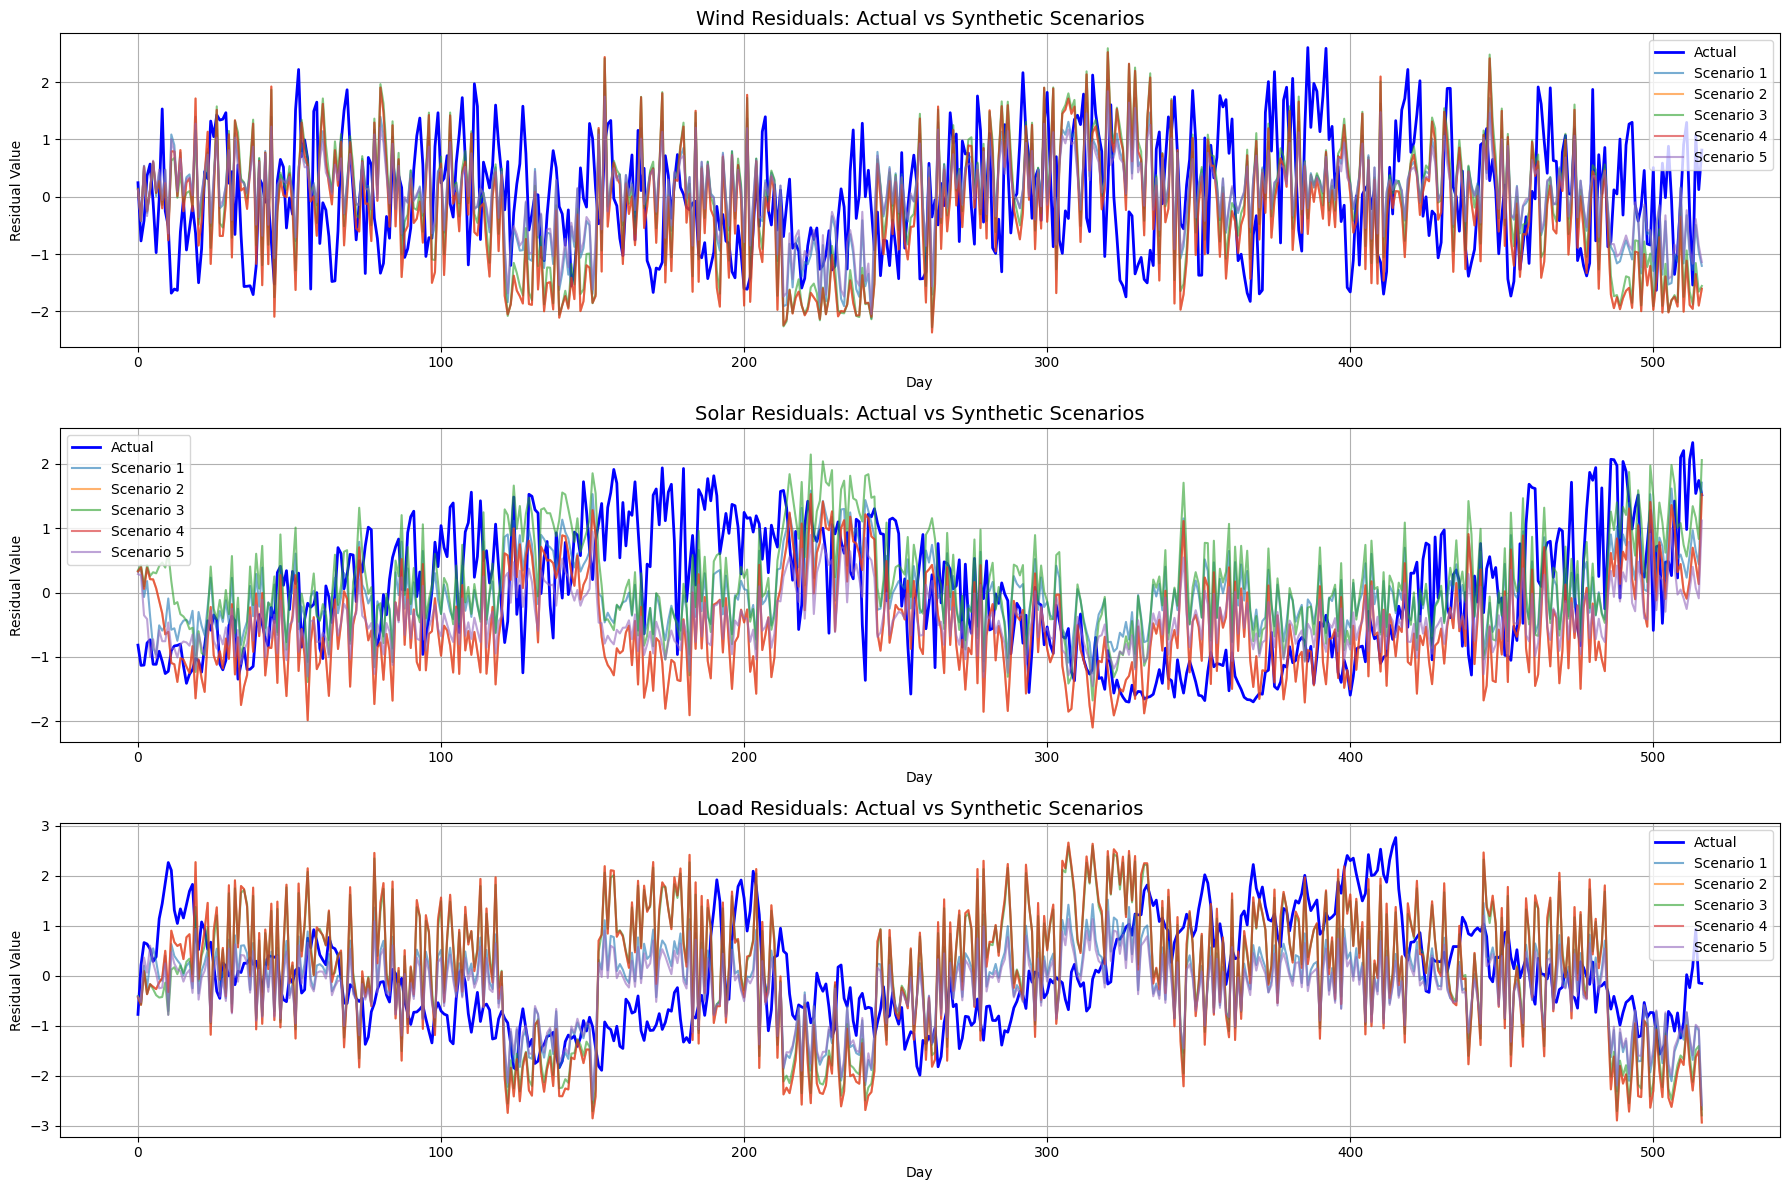

In [23]:
actual_df = pd.read_csv("/kaggle/input/test-data/2024-2025.csv")
scenarios = np.load("residual_sims.npy")  

# === Plotting ===
features = ["Wind", "Solar", "Load"]
residual_cols = [f"{f}_Residual" for f in features]
time = np.arange(scenarios.shape[1])

plt.figure(figsize=(18, 12))
for i, col in enumerate(residual_cols):
    plt.subplot(3, 1, i+1)
    
    # Plot actual
    plt.plot(actual_df[col].values[:517], label="Actual", color="blue", linewidth=2)

    # Plot 5 random scenarios
    for j in range(min(5, scenarios.shape[0])):
        plt.plot(scenarios[j, :, i], label=f"Scenario {j+1}", alpha=0.6)

    plt.title(f"{features[i]} Residuals: Actual vs Synthetic Scenarios", fontsize=14)
    plt.xlabel("Day")
    plt.ylabel("Residual Value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
